## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
# import torch.onnx

from relaynet_pytorch.relay_net import ReLayNet
from relaynet_pytorch.data_utils import get_imdb_data
from helper import * # import helper functions

# from networks.relay_net import ReLayNet
#from networks.data_utils import get_imdb_data

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

# Helper Functions

In [3]:
import torch.nn.functional as F

#### OP of ReLayNet

In [4]:
def relay_out(test_data):
    '''
    output of relaynet - takes test data in form (1,1,height, width)
    '''
    out = relaynet_model(Variable(torch.cuda.FloatTensor(test_data)))
    out = F.softmax(out,dim=1)
    max_val, idx = torch.max(out,1) # torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)
    return max_val, idx

#### Coloured Labelling

In [5]:
SEG_LABELS_LIST = [
    {"id": -1, "name": "void", "rgb_values": [0, 0, 0]},
    {"id": 0, "name": "Region above the retina (RaR)", "rgb_values": [128, 0, 0]}, # dark red
    {"id": 1, "name": "ILM: Inner limiting membrane", "rgb_values": [0, 128, 0]}, # green
    {"id": 2, "name": "NFL-IPL: Nerve fiber ending to Inner plexiform layer", "rgb_values": [128, 128, 0]}, # weird green
    {"id": 3, "name": "INL: Inner Nuclear layer", "rgb_values": [0, 0, 128]}, # dark blue
    {"id": 4, "name": "OPL: Outer plexiform layer", "rgb_values": [128, 0, 128]}, # purple
    {"id": 5, "name": "ONL-ISM: Outer Nuclear layer to Inner segment myeloid", "rgb_values": [0, 128, 128]},
    {"id": 6, "name": "ISE: Inner segment ellipsoid", "rgb_values": [128, 128, 128]},
    {"id": 7, "name": "OS-RPE: Outer segment to Retinal pigment epithelium", "rgb_values": [64, 0, 0]},
    {"id": 8, "name": "Region below RPE (RbR)", "rgb_values": [192, 0, 0]}];
    #{"id": 9, "name": "Fluid region", "rgb_values": [64, 128, 0]}];
    
def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img)
    labels = np.unique(label_img)
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]

    label_img_rgb = np.array([label_img,
                              label_img,
                              label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']

    return label_img_rgb.astype(np.uint8)

#### Show Image file

In [6]:
def show_image(idxs):
    '''
    show image file using idxs
    '''
    idxs = idxs.data.cpu().numpy()
    idxs = label_img_to_rgb(idxs)
    plt.imshow(idxs)
    plt.show()

#### Segment Image Helpers

In [7]:
def show_seg_image(idxs, nx, ny, i):
    '''
    show image file using idxs
    '''
    idxs = idxs.data.cpu().numpy()
    idxs = label_img_to_rgb(idxs)
    plt.subplot(Nx, Ny, i)  # next plot will be shown in
                        # first subplot in Nx x Ny
                        # matrix of subplots
    plt.imshow(idxs)

In [8]:
def get_segmented_image(data, height, width, left_bound, right_bound, split, Ny, Nx):
    # Segments from image
    segments = segment_image(seg_test,left_bound,right_bound,split)

    for i in range(1,len(segments)+1):
        segments[i-1].shape = (1, 1, height ,split)

        # Getting ReLayNet max_val, idx classification values
        max_val_trans, idx_trans = relay_out(segments[i-1])

        # Test image
        show_seg_image(idx_trans, Nx, Ny, i)
    plt.show()

#### Show Legend For Images

In [9]:
def show_legend():
    import PIL
    from PIL import ImageFont
    from PIL import Image
    from PIL import ImageDraw


    font = ImageFont.truetype("/usr/share/fonts/truetype/DejaVuSans.ttf",10)
    img=Image.new("RGBA", (300,350),(256,256,256))
    draw = ImageDraw.Draw(img)
    val = 0
    for i in range(1,len(SEG_LABELS_LIST)):
        item = SEG_LABELS_LIST[i]
        name = item['name']
        fill = tuple(item['rgb_values'])
        draw.text((10,val), name, fill, font=font)
        val += 40

    imgplot = plt.imshow(img)
    plt.show()

## Read in Model

First Line below removes warnings from ReLayNet

In [10]:
%%capture --no-stdout 

## My adapted code
from torch.utils.serialization import load_lua
model = cwd + '/models/Exp01/relaynet_epoch20.model'
# model = cwd + '/models/relaynet_good.model'

# load the model
relaynet_model = torch.load(model).cuda()

In [11]:
# Printing the test data and the weights for the layers out
# relaynet_model # architecture of the net
# relaynet_model.eval()

In [12]:
# list(relaynet_model.encode1.parameters()) # weights on certain layers

In [13]:
# Printing model weights
# w = list(relaynet_model.parameters())
# w
# for param in relaynet_model.parameters():
#   print(param.data)
# list(relaynet_model.parameters()) # all weights

In [14]:
# print(torch.__version__)
# torch.cuda.FloatTensor(10)

## Load Image

In [15]:
# file = '/datasets/ResizedImages'
# file = '/datasets/DenoiseImages/DenoisedTrainImages/denoised_5.png'
file = '/datasets/con_H1_N01848_LV_1_194.tif'
# file = '/datasets/con_H1_N01848_LA_1_272.tif'
# file = '/datasets/con_H1_N01848_LA_1_272_denoised.png'
# file = '/datasets/test_image.png'

directory = cwd + file

# # Seeing whether file exists
image = plt.imread(directory)

test_data = image
test_data.shape
# # test_data = test_data[:,:,0]

(512, 600)

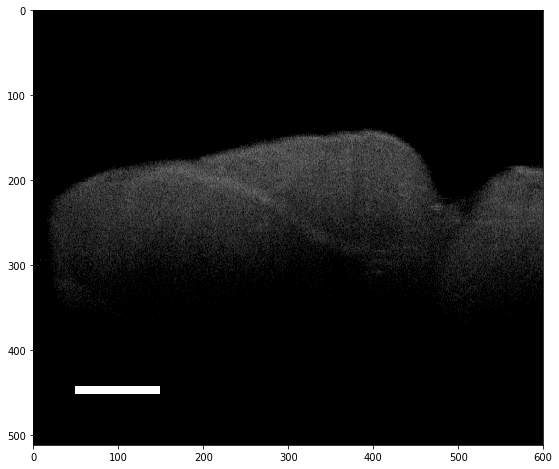

In [16]:
plt.imshow(test_data,cmap = "gray")

# Deploy Model on Test Data

## Different Size Segmentation

Helpful Source: https://www.southampton.ac.uk/~fangohr/teaching/python/book/html/15-visualising-data.html

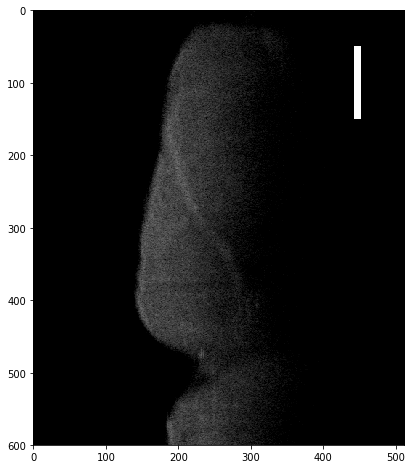

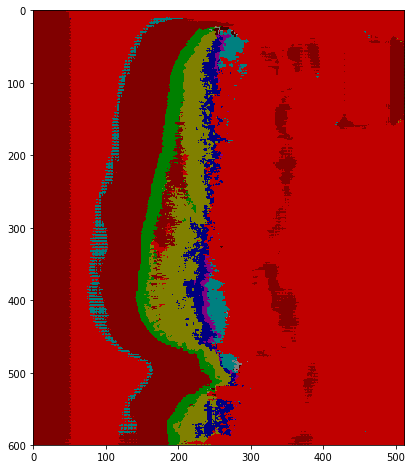

In [17]:
# Main Image
img_test = np.transpose(test_data, (1,0)) # transpose as changes direction of image 
# img_test = test_data
show_main_image(img_test)

seg_test = np.copy(test_data) # Copy so it doesn't alter init dimensions of test_data

seg_test.shape = (1,1,512,600) # Change dimensions of data
seg_test = np.transpose(seg_test, (0, 1, 3, 2)) # Transposing - changes rotation of image

# Getting ReLayNet max_val, idx classification values
max_val_trans, idx_trans = relay_out(seg_test)
show_image(idx_trans)

# Settings for segmentation
seg_test = np.squeeze(seg_test)
height, width = seg_test.shape
left_bound = 0
right_bound = width
split = 40 # must be mutiples of 8
Ny = width/split
Nx = 1

# Show Segmentations
# get_segmented_image(seg_test, height, width, left_bound, right_bound, split, Ny, Nx)

## Transpose vs Not Transpose

### Transpose

In [18]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

#### Useful sources:

* https://pytorch.org/docs/stable/torchvision/datasets.html

* https://github.com/pytorch/tutorials/issues/78 

* https://pytorch.org/docs/stable/torchvision/transforms.html

* https://www.google.co.uk/search?q=torch+split+image+then+join+image&oq=torch+split+image+then+join+image+&aqs=chrome..69i57.15014j0j4&sourceid=chrome&ie=UTF-8

* https://pytorch.org/docs/master/torchvision/transforms.html

* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=torchvision

* https://stackoverflow.com/questions/29434729/torch-resize-tensor

* https://pytorch.org/docs/stable/torchvision/datasets.html

In [19]:
# class FaceLandmarksDataset(Dataset):
#     """Face Landmarks dataset."""

#     def __init__(self, root_dir, transform=None):
#         """
#         Args:
#             csv_file (string): Path to the csv file with annotations.
#             root_dir (string): Directory with all the images.
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
# #         self.landmarks_frame = pd.read_csv(csv_file)
#         self.root_dir = root_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.landmarks_frame)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir,
#                                 self.landmarks_frame.iloc[idx, 0])
#         image = io.imread(img_name)
#         landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
#         landmarks = landmarks.astype('float').reshape(-1, 2)
#         sample = {'image': image, 'landmarks': landmarks}

#         if self.transform:
#             sample = self.transform(sample)

#         return sample

In [20]:
# Also included in original train ReLayNet - 3rd line he uses DataLoader.

# # Load mutiple images in - https://medium.com/@yvanscher/pytorch-tip-yielding-image-sizes-6a776eb4115b
# transform = transforms.Compose([
#     # you can add other transformations in this list
#     transforms.ToTensor()
# ])
# data = ImageFolder('/home/sim/notebooks/relaynet_pytorch/datasets/OCTlabel041818', transform)
# data_loader = torch.utils.data.DataLoader(dataset=data,
#                              batch_size=1,
#                              shuffle=False,
#                              num_workers=1)


# for batch in data_loader:
#     print(batch[0].size())

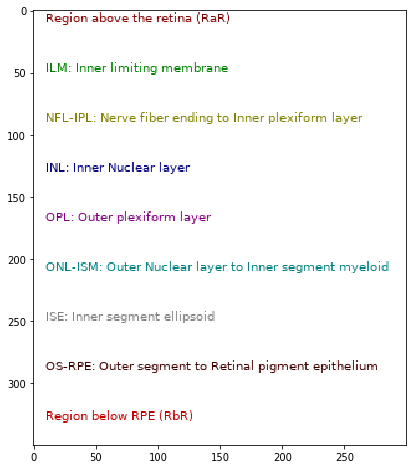

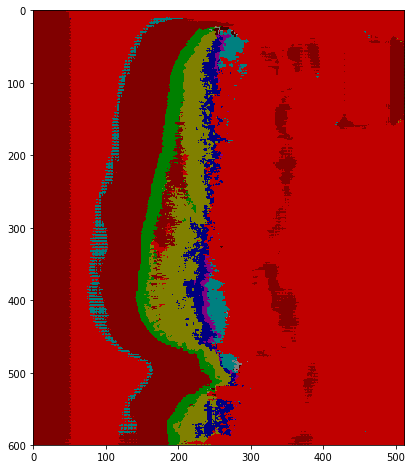

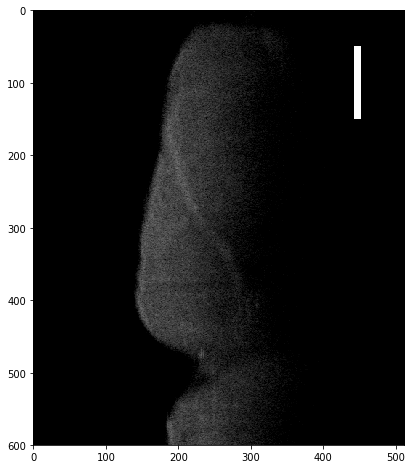

In [21]:
new_test = np.copy(test_data) # Copy so it doesn't alter init dimensions of test_data

new_test.shape = (1,1,512,600) # Change dimensions of data
# new_test = new_test[:400,:400]
# new_test.shape = (1,1,400,400)
new_test = np.transpose(new_test, (0, 1, 3, 2)) # Transposing - changes rotation of image

# Getting ReLayNet max_val, idx classification values
max_val_trans, idx_trans = relay_out(new_test)

# show legend
show_legend()

# Test image
show_image(idx_trans)

# Main Image
img_test = np.transpose(test_data, (1,0)) # transpose as changes direction of image 
show_main_image(img_test)

### Not Transpose

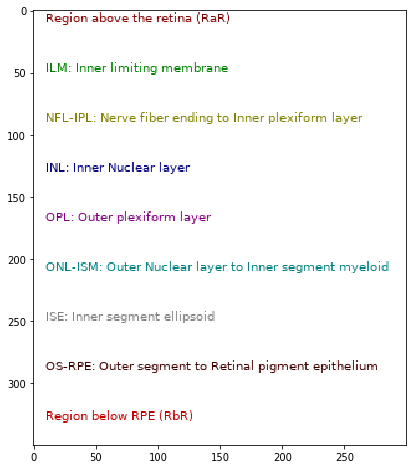

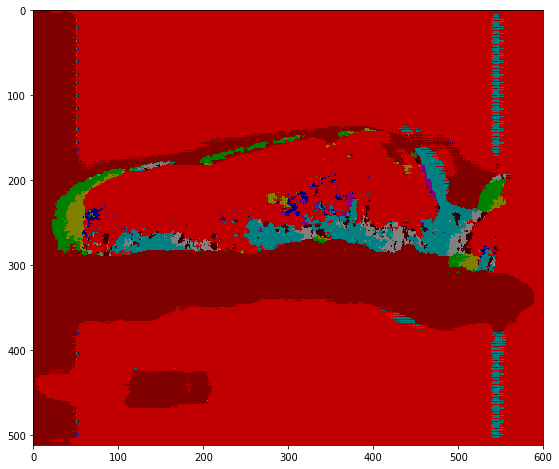

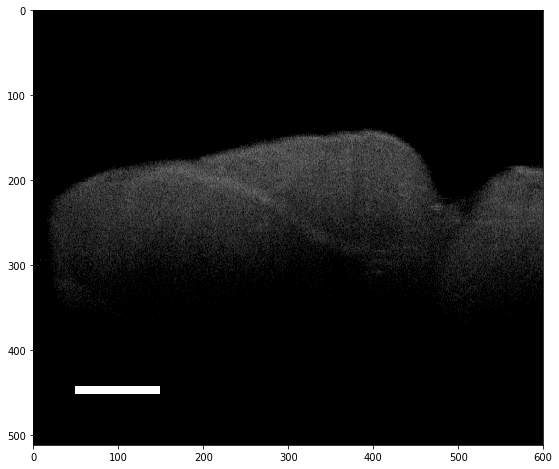

In [22]:
new_test = np.copy(test_data) # Copy so it doesn't alter init dimensions of test_data
new_test.shape = (1,1,512,600) # Change dimensions of data

# Getting ReLayNet max_val, idx classification values
max_val, idx = relay_out(new_test)

# Show legend
show_legend()

# Test image
show_image(idx)

# Main Image
img_test = test_data
show_main_image(img_test)

# Metrics

#### Dice Score

Source: https://stats.stackexchange.com/questions/195006/is-the-dice-coefficient-the-same-as-accuracy

* Dice Score: relaynet_pytorch - solver.py in train function.
* Dice Score: networks -> net_api -> losses.py in class DiceCoeff as well as DiceLoss
* TF Dice Score: Line 42 in ReLayNey_model.ipynb

In [23]:
avg_dice = per_class_dice(batch_output, y, self.NumClass)
print('Per class average dice score is ' + str(avg_dice))

NameError: name 'per_class_dice' is not defined

## Data types

##### Testing data Dimensions

In [ ]:
# X = np.zeros((512,600)) # create numpy array of size 512 x 600
# data = np.array([[11, 22, 33, 44, 55],[2,3,4,5,6],[10,20,30,40,50]])
# print(data[:,0])
# print(type(test_data))
# print(test_data.shape)
# print(test_data.dtype)
# new_test_data = np.zeros((512,600))

##### Data input

In [ ]:
# # Dummy Input
# # Input is organised [No., Channel, Width, Height] - [1,1,64,512]
# # Float tensor because weights are float Tensors

# dummy_input = Variable(torch.cuda.FloatTensor(1,1,64,512)) # has to be (1,1,...) because the first is no. therefore can't plot 2d image on same plot.
# # print(dummy_input)
# # Getting ReLayNet max_val, idx classification values
# max_val_trans, idx_trans = relay_out(dummy_input)

# # Test image
# show_image(idx_trans)

# # new_test = np.transpose(new_test, (0, 1, 3, 2)) # Transposing changes rotation of image

### Export Model
##### Date:  13/07/2018 
Can't export model as MaxPool2d with index output is not supported in ONNX: https://discuss.pytorch.org/t/problems-converting-pytorch-model-into-onnx/12192/3.


In [24]:
# Removed code from batchnorm.py for all references to track_running_stats - see comments in the code

# relaynet_model.eval()
# dummy_input = Variable(torch.cuda.FloatTensor(1,1,600,64)) # has to be (1,1,...) because the first is no. therefore can't plot 2d image on same plot.
# torch.onnx.export(relaynet_model, dummy_input, "model.onnx", verbose=True)

### Open Matlab Files

In [25]:
# import scipy.io as sio